# Investigation of a surfactant monolayer

A common system that is studied with neutron and X-ray reflectometry are surfactant monolayers. 
In this tutorial, we will look at how the `easyreflectometry` assembly `SurfactantLayer` ([detailed here](../basic/assemblies_library.rst#surfactantlayer)) can be used to model a phospholipid bilayer. 
First, we will import the relevant packages and functions.

First configure matplotlib to place figures in notebook and import needed modules. Note that the plot function needs installation of `plopp` seperately or installation of `easyreflectometry[dev]`

In [1]:
%matplotlib inline

import refnx
import pooch

import easyreflectometry

from easyreflectometry.calculators import CalculatorFactory
from easyreflectometry.data import load
from easyreflectometry.plot import plot
from easyreflectometry.sample import Material
from easyreflectometry.sample import SurfactantLayer
from easyreflectometry.sample import LayerAreaPerMolecule
from easyreflectometry.sample import Layer
from easyreflectometry.sample import Multilayer
from easyreflectometry.sample import Sample
from easyreflectometry.model import Model
from easyreflectometry.model import PercentageFwhm
from easyreflectometry.fitting import MultiFitter
from easyreflectometry.plot import plot
from easyscience.fitting import AvailableMinimizers


Next, as usual we print the versions of the software packages. 

In [2]:
print(f'easyreflectometry: {easyreflectometry.__version__}')
print(f'refnx: {refnx.__version__}')

easyreflectometry: 1.3.1
refnx: 0.1.52


## Reading in experimental data

As has been [shown previously](../fitting/simple_fitting.ipynb), we use the `load` function to read in our experimental data. 
For this tutorial we will be looking at [DSPC](https://en.wikipedia.org/wiki/Distearoylphosphatidylcholine), a phospholipid molecule that will self-assemble into a monolayer at the air-water interface. 
The data being used has kindly been shared by the authors of [previous work on the system](https://doi.org/10.1021/la8028319)(Hollinshead et al. 2009). We use `pooch` to fetch the file from our repository.

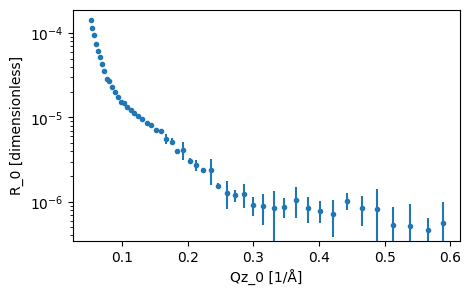

In [3]:
file_path = pooch.retrieve(
    # URL to one of Pooch's test files
    url="https://raw.githubusercontent.com/EasyScience/EasyReflectometryLib/master/docs/src/tutorials/fitting/d70d2o.ort",
    known_hash="3e4750536621be8eec493fa21a287e408d384f29cacb113b71d02690d99f0998",
)
data = load(file_path)
plot(data)

## Building the model

The study of surfactant monolayers is very popular in the literature, including the models based on [functional descriptions](https://doi.org/10.1021/la8028319)(Hollinshead et al. 2009), [slab models](https://doi.org/10.1016/j.jcis.2018.07.022)(Campbell et al. 2018), and [molecular dynamics simulations](https://doi.org/10.1088/2399-6528/ab12a9) (McCluskey et al. 2019). 
In `easyreflectometry`, we use a slab model description taht has become particularly commonplace. 
A graphical representation of the slab model for a phosphoplipid monolayer is shown below.

<center>
    <img src='monolayer.png' alt='A slab model description for a phospholipid monolayer.' width='300px'></img>
</center>
<center>
    A slab model description for a phospholipid monolayer, showing the head and tail layers.
</center>

The slab model for a phospholipid monolayer involves describing the system as consisting of two components, that for the hydrophilic head group layer and that for the hydrophobic tail group layer. 
Each of these layers have some thickness that can be estimated by considering the size of the head and tail groups.
The scattering length density (<mi>ρ</mi>) for the layers is then defined based on the layer thickness (<mi>d</mi>), the scattering length for the lipid head or tail molecule (<mi>b</mi>), the surface number density of the monolayer (defined by the area per molecule, APM) and the presence of solvent in the head or tail molecules (<mi>ϕ</mi> solvation), where the solvent has a known scattering length density (<mi>ρ</mi> solvent),

<center>
    <img src="eq_monolayer.svg" title="\rho=\frac{b}{d\mathrm{APM}}(1-\phi)+\rho_{\mathrm{solvent}}\phi" />
</center>
<!-- Using https://editor.codecogs.com/ -->

This approach has two benefits: 
1. By constraining the area per molecule of the head and tail groups to be the same, the analysis can ensure that the number density of the two components is equal (i.e. for every head group there is a tail group), as would be expected given the chemical bonding.
2. The area per molecule is a parameter that can be measured using complementary methods, such as surface-pressure isotherm, to help define the value.

Finally, we can constrain the roughness between head-tail and tail-superphase layers to be the same value, as it is unlikely that it would be different. 

Before we create the `SurfactantLayer` object, we will create simple `Material` objects for the sub- and super-phase. 

In [4]:
d2o = Material(sld=6.36, isld=0, name='D2O')
air = Material(sld=0, isld=0, name='Air')

### Building the surfactant monolayer

Now we can create the `SurfactantLayer` object, this takes a large number of parameters, that we will introduce gradually. 

<center>
    <img src='dspc.png' alt='The chemical structure for the DSPC molecule.'></img>
</center>
<center>
    The chemical structure for the DSPC molecule. By <a href='https://commons.wikimedia.org/w/index.php?curid=97726650'>Graeme Bartlett - Self Drawn, CC0</a>
</center>

The chemical structure for the DSPC molecule is shown above, where the head group is everything to the right of (and including) the ester group as this is the hydrophilic component. 
While, everything to the left hand side is the tail group (both chains are included).
We want to define the chemical formula for each of these subunits. 

In [5]:
head_formula = 'C10H18NO8P'
tail_formula = 'C34D70'

Next we define estimates for the thickness of each layer, for this we will use values from [a previous work](https://doi.org/10.1088/2632-2153/ab94c4)(McCluskey et al. 2020), as we will not be varying these parameters. 

In [6]:
head_thickness = 12.9
tail_thickness = 17.6

We expect the head layer to be solvated with some of the D<sub>2</sub>O present, however it is unlikely that there will be any solvent surface coverage (by D<sub>2</sub>O or air) in the tighly packed tails. 

In [7]:
head_solvent_fraction = 0.5
tail_solvent_fraction = 0.0

Finally, we define the values for the area per molecule and roughness for the whole surfactant layer. 

In [8]:
area_per_molecule = 45
roughness = 3

Having created the necessary initial values, we can use these to create a `SurfactantLayer` object. 
Note that the area per molecule and roughness for both layers are the same. 
We can also print information about our surfactant system.

In [9]:
tail_layer = LayerAreaPerMolecule(
    molecular_formula=tail_formula,
    thickness=tail_thickness,
    solvent=air,
    solvent_fraction=tail_solvent_fraction, 
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
head_layer = LayerAreaPerMolecule(
    molecular_formula=head_formula,
    thickness=head_thickness,
    solvent=d2o,
    solvent_fraction=head_solvent_fraction, 
    area_per_molecule=area_per_molecule,
    roughness=roughness
)
dspc = SurfactantLayer(
    tail_layer=tail_layer,
    head_layer=head_layer
)
dspc.constrain_area_per_molecule = True
dspc.conformal_roughness = True
dspc

EasySurfactantLayer:
  head_layer:
    EasyLayerAreaPerMolecule:
      material:
        C10H18NO8P in D2O:
          solvent_fraction: 0.500 dimensionless
          sld: 3.697e-6 1/Å^2
          isld: 0.000e-6 1/Å^2
          material:
            C10H18NO8P:
              sld: 1.035e-6 1/Å^2
              isld: 0.000e-6 1/Å^2
          solvent:
            D2O:
              sld: 6.360e-6 1/Å^2
              isld: 0.000e-6 1/Å^2
      thickness: 12.900 Å
      roughness: 3.000 Å
    molecular_formula: C10H18NO8P
    area_per_molecule: 45.00 Å^2
  tail_layer:
    EasyLayerAreaPerMolecule:
      material:
        C34D70 in Air:
          solvent_fraction: 0.000 dimensionless
          sld: 8.747e-6 1/Å^2
          isld: 0.000e-6 1/Å^2
          material:
            C34D70:
              sld: 8.747e-6 1/Å^2
              isld: 0.000e-6 1/Å^2
          solvent:
            Air:
              sld: 0.000e-6 1/Å^2
              isld: 0.000e-6 1/Å^2
      thickness: 17.600 Å
      roughness

The layers for the sub- and super-phase are then created. 

In [10]:
d2o_layer = Layer(material=d2o, thickness=0, roughness=3, name='D2O Subphase')
air_layer = Layer(material=air, thickness=0, roughness=0, name='Air Superphase')

For the surfactant layer, the roughness is typically defined by the roughness between the water-head layers. 
Therefore, it is desirable to add this constraint to our model.

In [11]:
dspc.constrain_solvent_roughness(d2o_layer.roughness)

Now that the surfactant layer and sub- and super-phases are available and the necessary constraints present, we construct our `Sample` and `Model` objects. 

In [12]:
resolution_function = PercentageFwhm(5)
sample = Sample(Multilayer(air_layer), dspc, Multilayer(d2o_layer))
model = Model(
    sample=sample,
    scale=1,
    background=data['data']['R_0'].values.min(),
    resolution_function=resolution_function
)

For the `model` we set the background initially as the minimum value observed in the experimental data. 

## Defining bounds and performing the optimisation

The varying parameters can then be defined, in this case we will let the scale factor, the background, the surfactant area per molecule, and head layer solvent surface coverage vary with the bounds shown below. 

In [13]:
model.scale.bounds = (0.05, 1.5)
model.background.bounds = (4e-7, 1e-6)

dspc.tail_layer.area_per_molecule_parameter.bounds = (30, 60)
dspc.head_layer.solvent_fraction_parameter.bounds = (0.4, 0.7)

Finally, as with other [tutorials](../tutorials.rst), we create the `CalculatorFactory` (and connect this to our model) and `MultiFitter` objects and perform the fit. 

In [14]:
calculator = CalculatorFactory()
model.interface = calculator
fitter = MultiFitter(model)
fitter.switch_minimizer(AvailableMinimizers.LMFit_differential_evolution)
analysed = fitter.fit(data)

The result can then be plotted, before we investigate the results. 

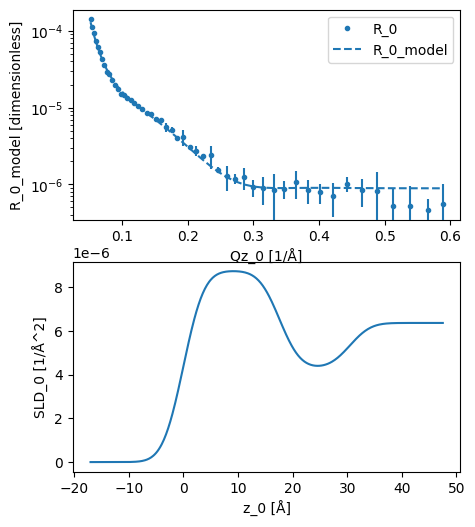

In [15]:
plot(analysed)

In [16]:
model

EasyModel:
  scale: 0.14052644753863197
  background: 8.86814517267836e-07
  resolution: 5 %
  color: black
  sample:
    EasySample:
    - EasyMultilayer:
        Air Superphase:
        - Air Superphase:
            material:
              Air:
                sld: 0.000e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
            thickness: 0.000 Å
            roughness: 0.000 Å
    - EasySurfactantLayer:
        head_layer:
          EasyLayerAreaPerMolecule:
            material:
              C10H18NO8P in D2O:
                solvent_fraction: 0.622 dimensionless
                sld: 4.305e-6 1/Å^2
                isld: 0.000e-6 1/Å^2
                material:
                  C10H18NO8P:
                    sld: 0.924e-6 1/Å^2
                    isld: 0.000e-6 1/Å^2
                solvent:
                  D2O:
                    sld: 6.360e-6 1/Å^2
                    isld: 0.000e-6 1/Å^2
            thickness: 12.900 Å
            roughness: 3.000 Å
          molecular_form

We can see above that the solvent surface coverage of the surfactant was found to be around 60 % (solvent_fraction in head_layer) and the area per molecule around 50 Å<sup>2</sup>, in agreement with [previous investigations](https://doi.org/10.1088/2399-6528/ab12a9) (McCluskey et al. 2019). 

## References 

Hollinshead, C. M., Harvey, R. D., Barlow, D. J., Webster, J. R. P., Hughes, A. V., Weston, A., Lawrence, M. J., **2009**,
*Effects of Surface Pressure on the Structure of Distearoylphosphatidylcholine Monolayers Formed at the Air/Water Interface*,
[Langmuir, 25, 4070-4077](https://doi.org/10.1021/la8028319)


Campbell, R. A., Saaka, Y., Shao, Y., Gerelli, Y., Cubitt, R., Nazaruk, E., Matyszewska, D. Lawrence, M. J., **2018**,
*Structure of surfactant and phospholipid monolayers at the air/water interface modeled from neutron reflectivity data*,
[Journal of Colloid and Interface Science, 531, 98-108](https://doi.org/10.1016/j.jcis.2018.07.022)

McCluskey, A. R., Grant, J., Smith, A. J., Rawle, J. L., Barlow, D. J., Lawrence, M. J., Parker, S. C., Edler, K. J., **2019**,
*Assessing molecular simulation for the analysis of lipid monolayer reflectometry*,
[Journal of Physics Communications, 3, 075001](https://doi.org/10.1088/2399-6528/ab12a9)

McCluskey, A. R., Cooper, J. F. K., Arnold, T., Snow, T., **2020**,
*A general approach to maximise information density in neutron reflectometry analysis*,
[Machine Learning: Science and Technology, 1, 035002](https://doi.org/10.1088/2632-2153/ab94c4)